In [1]:
import pandas as pd
import numpy as np
import math
import scipy
import pywt
from scipy.integrate import trapz,cumtrapz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy import signal
plt.style.use('seaborn')

In [2]:
df_linear = pd.read_csv('Xue/tiltleft6/globalAcce.csv',header=0,names=['global','1','2','3'])
df_gyro = pd.read_csv('Xue/tiltleft6/gyro.csv',header=0,names=['gyro','1','2','3'])
df_angle = pd.read_csv('Xue/tiltleft6/rotationAngles.csv',header=0,names=['angle','1','2','3'])
dt = 0.005

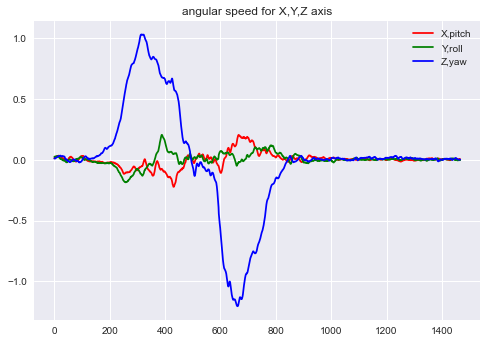

In [3]:
plt.title('angular speed for X,Y,Z axis')
plt.plot(df_gyro['1'],color = 'red', label = 'X,pitch')
plt.plot(df_gyro['2'],color = 'green', label = 'Y,roll')
plt.plot(df_gyro['3'],color = 'blue', label = 'Z,yaw')
plt.legend()
plt.show()

In [4]:
# # for nodding
# part1 = np.where(df_gyro['2']<-0.08)[0]
# part2 = np.where(df_gyro['2']>0.08)[0]
# for tilt
part1 = np.where(df_gyro['3']<-0.08)[0]
part2 = np.where(df_gyro['3']>0.08)[0]
index = np.sort([part1[0],part1[-1],part2[0],part2[-1]])
start1 = index[0]
end1 = index[1]
start2 = index[2]
end2 = index[3]
# start1 = 224
# end1 = 542
# start2 = 638
# end2 = 923

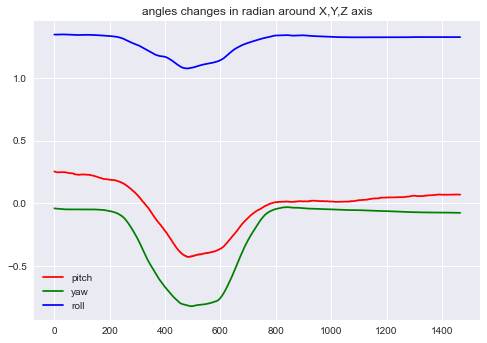

In [5]:
plt.title('angles changes in radian around X,Y,Z axis')
plt.plot(df_angle['1'],color = 'red', label = 'pitch')
plt.plot(df_angle['2'],color = 'green', label = 'yaw')
plt.plot(df_angle['3'],color = 'blue', label = 'roll')
plt.legend()
plt.show()

In [6]:
# angle changed during movement
pitch1 = abs(df_angle['1'][end1]-df_angle['1'][start1])
pitch2 = abs(df_angle['1'][end2]-df_angle['1'][start2])
yaw1 = abs(df_angle['2'][end1]-df_angle['2'][start1])
yaw2 = abs(df_angle['2'][end2]-df_angle['2'][start2])
roll1 = abs(df_angle['3'][end1]-df_angle['3'][start1])
roll2 = abs(df_angle['3'][end2]-df_angle['3'][start2])

In [7]:
acceX = np.array(df_linear['1'])
acceY = np.array(df_linear['2'])
acceZ = np.array(df_linear['3'])

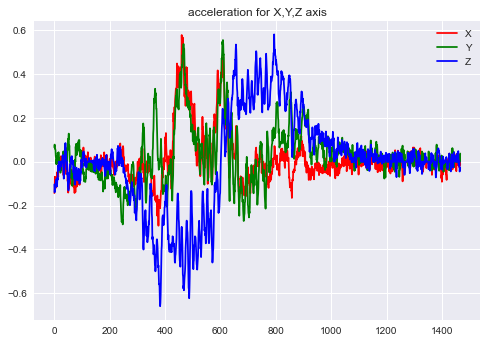

In [8]:
plt.title('acceleration for X,Y,Z axis')
plt.plot(acceX,color = 'red', label = 'X')
plt.plot(acceY,color = 'green', label = 'Y')
plt.plot(acceZ,color = 'blue', label = 'Z')
plt.legend()
plt.show()

In [9]:
def acceleration_integration(acceX, acceY, acceZ):
    vx = np.zeros(len(acceX))
    vy = np.zeros(len(acceY))
    vz = np.zeros(len(acceZ))
    for i in range (1, len(acceX)-1):
        vx[i] = vx[i-1]+(acceX[i-1]+4*acceX[i]+acceX[i+1])*dt/6
        vy[i] = vy[i-1]+(acceY[i-1]+4*acceY[i]+acceY[i+1])*dt/6
        vz[i] = vz[i-1]+(acceZ[i-1]+4*acceZ[i]+acceZ[i+1])*dt/6
    return vx,vy,vz

In [10]:
def velocity_integration(velocityX, velocityY, velocityZ):
    positionX = np.zeros(len(velocityX))
    positionY = np.zeros(len(velocityX))
    positionZ = np.zeros(len(velocityX))
    for i in range (1, len(velocityX)-1):
        positionX[i] = positionX[i-1] +(velocityX[i-1]+4*velocityX[i]+velocityX[i+1])*dt/6
        positionY[i] = positionY[i-1] +(velocityY[i-1]+4*velocityY[i]+velocityY[i+1])*dt/6
        positionZ[i] = positionZ[i-1] +(velocityZ[i-1]+4*velocityZ[i]+velocityZ[i+1])*dt/6
    return positionX, positionY, positionZ

In [11]:
def wavelets(data, wavelet, uselevels, mode):
    levels = (np.floor(np.log2(df_linear['1'].shape[0]))).astype(int)
    omit = levels - uselevels
    coeffs = pywt.wavedec(data, wavelet, level=levels)
    A = pywt.waverec(coeffs[:-omit] + [None] * omit, wavelet, mode=mode)
    return A

In [12]:
# detrend
acceXdetrend = signal.detrend(acceX)
acceYdetrend = signal.detrend(acceY)
acceZdetrend = signal.detrend(acceZ)

In [13]:
Axwave = wavelets(data = acceXdetrend, wavelet = 'haar', uselevels = 7, mode = 'zero')
Aywave = wavelets(data = acceYdetrend, wavelet = 'haar', uselevels = 7, mode = 'zero')
Azwave = wavelets(data = acceZdetrend, wavelet = 'haar', uselevels = 7, mode = 'zero')

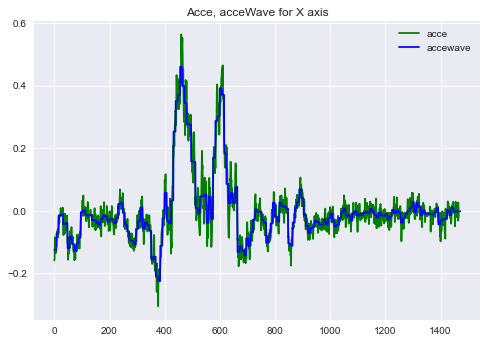

In [14]:
plt.title('Acce, acceWave for X axis')
plt.plot(acceXdetrend,color = 'green', label = 'acce')
plt.plot(Axwave,color = 'blue', label = 'accewave')
plt.legend()
plt.show()

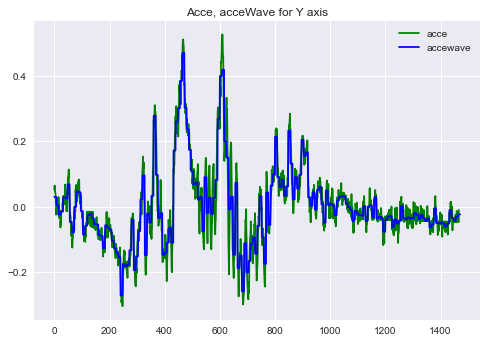

In [15]:
plt.title('Acce, acceWave for Y axis')
plt.plot(acceYdetrend,color = 'green', label = 'acce')
plt.plot(Aywave,color = 'blue', label = 'accewave')
plt.legend()
plt.show()

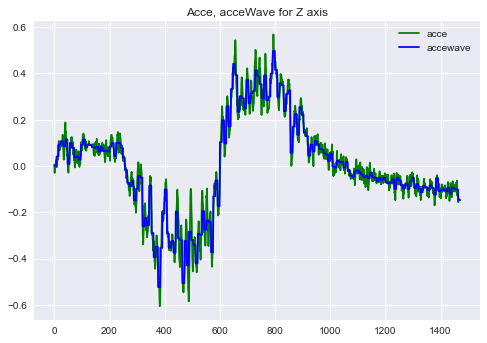

In [16]:
plt.title('Acce, acceWave for Z axis')
plt.plot(acceZdetrend,color = 'green', label = 'acce')
plt.plot(Azwave,color = 'blue', label = 'accewave')
plt.legend()
plt.show()

In [17]:
v = acceleration_integration(acceXdetrend,acceYdetrend,acceZdetrend)
# v = acceleration_integration(acceX,acceY,acceZ)
velocityX = v[0]
velocityY = v[1]
velocityZ = v[2]

In [18]:
position = velocity_integration(velocityX, velocityY, velocityZ)
positionX = position[0]
positionY = position[1]
positionZ = position[2]

In [19]:
vwave = acceleration_integration(Axwave,Aywave,Azwave)
velocityXwave = vwave[0]
velocityYwave = vwave[1]
velocityZwave = vwave[2]

In [20]:
positionwave = velocity_integration(velocityXwave, velocityYwave, velocityZwave)
positionXwave = positionwave[0]
positionYwave = positionwave[1]
positionZwave = positionwave[2]

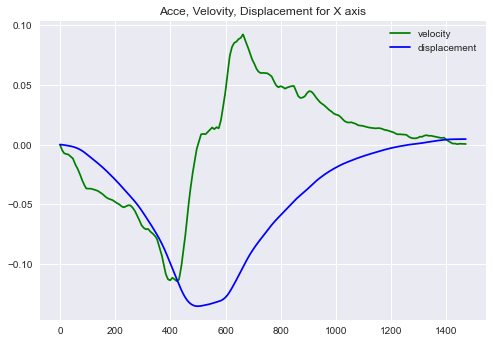

In [21]:
plt.title('Acce, Velovity, Displacement for X axis')
# plt.plot(df_linear['1'],color = 'red', label = 'acceleration')
plt.plot(velocityXwave[:-1],color = 'green', label = 'velocity')
plt.plot(positionXwave[:-1],color = 'blue', label = 'displacement')
plt.legend()
plt.show()

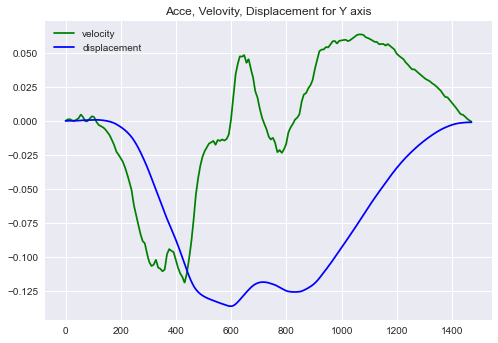

In [22]:
plt.title('Acce, Velovity, Displacement for Y axis')
# plt.plot(df_linear['1'],color = 'red', label = 'acceleration')
plt.plot(velocityYwave[:-1],color = 'green', label = 'velocity')
plt.plot(positionYwave[:-1],color = 'blue', label = 'displacement')
plt.legend()
plt.show()

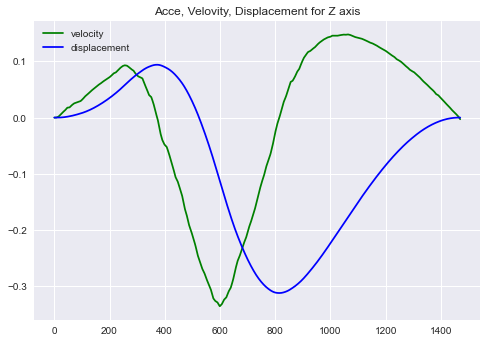

In [23]:
plt.title('Acce, Velovity, Displacement for Z axis')
# plt.plot(df_linear['1'],color = 'red', label = 'acceleration')
plt.plot(velocityZwave[:-1],color = 'green', label = 'velocity')
plt.plot(positionZwave[:-1],color = 'blue', label = 'displacement')
plt.legend()
plt.show()

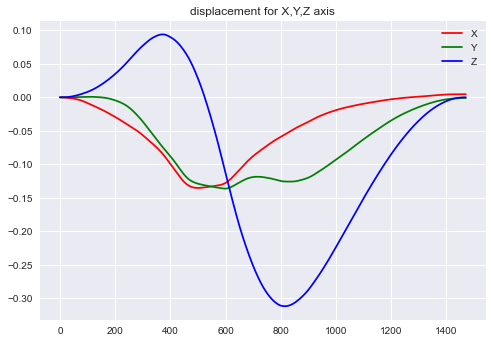

In [24]:
plt.title('displacement for X,Y,Z axis')
plt.plot(positionXwave[:-1],color = 'red', label = 'X')
plt.plot(positionYwave[:-1],color = 'green', label = 'Y')
plt.plot(positionZwave[:-1],color = 'blue', label = 'Z')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


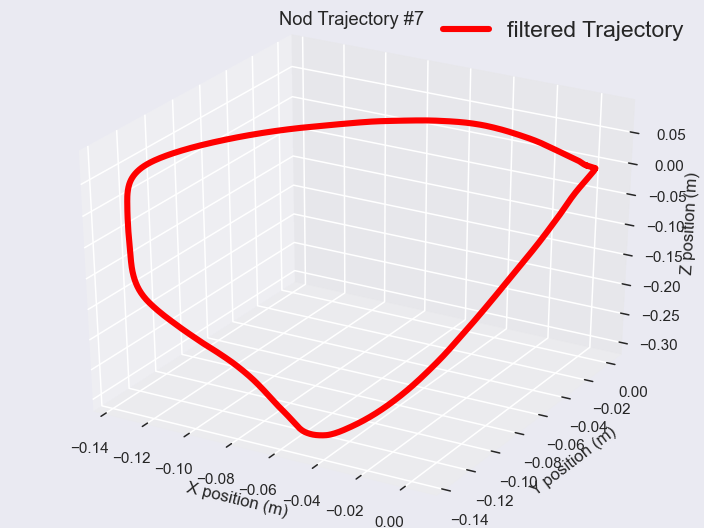

In [25]:
%matplotlib notebook
fig = plt.figure()
fig.suptitle('Nod Trajectory #7')
axes3d = Axes3D(fig)
axes3d.plot(positionXwave,positionYwave,positionZwave,c='red',lw = 4, label = 'filtered Trajectory')
axes3d.set_xlabel('X position (m)')
axes3d.set_ylabel('Y position (m)')
axes3d.set_zlabel('Z position (m)')
# axes3d.set_xlim([-0.2,0.2])
# axes3d.set_ylim([-0.2,0.2])
# axes3d.set_zlim([-0.2,0.2])
axes3d.legend(fontsize= 15)
plt.show()

In [26]:
def curvature_helper(point1, point2, point3):
    temp1 = np.cross(point2-point1, point3-point1)
    length12 = np.linalg.norm(point1-point2)
    length13 = np.linalg.norm(point1-point3)
    temp2 = np.cross(temp1, point2-point1)
    temp3 = np.cross(temp1, point3-point1)
    temp4 = (math.pow(length13,2)*temp2-math.pow(length12,2)*temp3)/math.pow(np.linalg.norm(temp1),2)/2
    coordinate = point1 + temp4
    radius = np.linalg.norm(temp4)
    if radius == 0:
        direction = coordinate 
    else:
        direction = coordinate.T/math.pow(radius,2)
    return radius, coordinate, direction

In [27]:
def curvature(trajectory):
    row = trajectory.shape[0]
    column = trajectory.shape[1]
    l = np.zeros((row,1))
    radius = np.full([row,1], np.nan)
    coordinate = np.full([row,3], np.nan)
    direction = np.full([row,3], np.nan)
    for i in range (1,row-1):
        radius[i] = curvature_helper(trajectory[i,:].T, trajectory[i-1,:].T, trajectory[i+1,:].T)[0]
        coordinate[i,:] = curvature_helper(trajectory[i,:].T, trajectory[i-1,:].T, trajectory[i+1,:].T)[1]
        direction[i,:] = curvature_helper(trajectory[i,:].T, trajectory[i-1,:].T, trajectory[i+1,:].T)[2]
        l[i] = l[i-1] + np.linalg.norm(trajectory[i,:]-trajectory[i-1,:])
        
    l[row-1] = l[row-2] + np.linalg.norm(trajectory[row-1,:] - trajectory[row-2,:]) 
    return l, radius, coordinate, direction

In [28]:
# positionXwaveR = np.concatenate((positionXwave[start1:end1],positionXwave[start2:end2]))
# positionYwaveR = np.concatenate((positionYwave[start1:end1],positionYwave[start2:end2]))
# positionZwaveR = np.concatenate((positionZwave[start1:end1],positionZwave[start2:end2]))

# positionXwaveR = positionXwave[start1:end1]
# positionYwaveR = positionYwave[start1:end1]
# positionZwaveR = positionZwave[start1:end1]

positionXwaveR = positionXwave[start2:end2]
positionYwaveR = positionYwave[start2:end2]
positionZwaveR = positionZwave[start2:end2]

In [29]:
trajectory = np.array([positionXwaveR, positionYwaveR, positionZwaveR]).T
radius = curvature(trajectory)[1]
coordinate = curvature(trajectory)[2]
l = curvature(trajectory)[0]

In [30]:
def least_square(coordinate,radius,positionXwaveR,positionYwaveR,positionZwaveR):
    d1 = coordinate[:,0]-positionXwaveR
    d2 = coordinate[:,1]-positionYwaveR
    d3 = coordinate[:,2]-positionZwaveR
    return np.power(np.sqrt(d1*d1+d2*d2+d3*d3)-radius,2)

In [31]:
lessRadius = radius[radius<1]
lessMean = np.mean(lessRadius)
radius[radius>1] = lessMean

<ipython-input-31-c5da1b12201e>:1: RuntimeWarning: invalid value encountered in less
  lessRadius = radius[radius<1]
<ipython-input-31-c5da1b12201e>:3: RuntimeWarning: invalid value encountered in greater
  radius[radius>1] = lessMean


In [32]:
distance = least_square(coordinate,radius,positionXwaveR,positionYwaveR,positionZwaveR)
leastq_collection = []
for i in range(0,len(distance)):
    temp = distance[i]
    leastq_collection.append(np.sum(temp[~np.isnan(temp)]))

In [33]:
index = np.argmin(leastq_collection[1:-1])
radius[index+1]

array([0.55084901])

In [34]:
leastq_collection[index+1]

214.56537413827058

In [35]:
print(yaw1)
print(pitch1)
print(roll1)
print(yaw2)
print(pitch2)
print(roll2)

0.7636000000000001
0.6183
0.25859999999999994
0.7837999999999999
0.4308
0.2563


In [36]:
[start1,end1,start2,end2]

[180, 489, 503, 826]

In [37]:
trajectory = np.array([positionXwaveR, positionYwaveR, positionZwaveR]).T
radius = curvature(trajectory)[1]
coordinate = curvature(trajectory)[2]
l = curvature(trajectory)[0]

In [38]:
for i in range(0,len(radius)-1):
    if radius[i]>1:
        radius[i]=np.nan

In [39]:
radius = radius[~np.isnan(radius)]
mean_radius = np.mean(radius)
print(mean_radius)

0.28298609276969844


In [40]:
# variance
variance = np.var(radius)
print(variance)

0.0486060077087517


In [41]:
# codfficient of variation
cv = np.std(radius)/np.mean(radius)
print(cv)

0.7790761024040808
